# Import Modules

In [204]:
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors

# Connect to Database

In [3]:
# connect to database
DB_PARAM_FILEPATH = os.path.join('C'+os.getcwd()[1:], '..', 'db_connection_params.csv')
db_params = pd.read_csv(DB_PARAM_FILEPATH)
db_host = db_params.host.iloc[0]
db_user = db_params.username.iloc[0]
db_pass = db_params.password.iloc[0]
db_name = db_params.database.iloc[0]
db_table = db_params.table.iloc[0]

print('Connecting to database...')
cnx = mysql.connector.connect(user = db_user, password = db_pass, host = db_host, database = db_name)
cursor = cnx.cursor(buffered=True)
print('Done connecting to database.')

Connecting to database...
Done connecting to database.


# Read Articles From Database

In [178]:
# read articles into dataframe
print('reading "articles" table')
query = 'SELECT * FROM articles'
# mysql package technically isn't supported, but this works fine
articles = pd.read_sql(query, cnx)
print('done reading "articles" table')
articles

reading "articles" table
done reading "articles" table


C:\Users\eeday\AppData\Local\Temp\ipykernel_32772\2079854182.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  articles = pd.read_sql(query, cnx)


,pmc_id,archive_href,abstract_text,pub_date,source,article_title
0,PMC7284390,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,the csp cell surface protein microsatellite ma...,2020-05-08,Microorganisms,Identification of CSP Types and Genotypic Vari...
1,PMC10478028,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,abstractseveral environmental chemicals are su...,2022-11-18,Cereb Cortex Commun,Fetal blockade of nicotinic acetylcholine tran...
2,PMC6494343,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,abstractchronic pulmonary aspergillosis cpa is...,2019-04-19,Medicine (Baltimore),"Evaluation of Aspergillus IgG, IgM antibody fo..."
3,PMC8501721,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,backgroundautism spectrum disorder asd is a co...,2021-10-09,BMC Neurosci,A systematic review of common genetic variatio...
4,PMC9620685,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background and aimstrategies to modify and adj...,2022-09-21,Autism Dev Lang Impair,Strategies in supporting inclusive education f...
...,...,...,...,...,...,...
935,PMC10046036,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,βfructofuranosidases ffases are enzymes involv...,2023-03-03,BioTech (Basel),"Production, Kinetic/Thermodynamic Study, and E..."
936,PMC7528686,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,the βclass of carbonic anhydrases βcas are zin...,2020-09-18,Mol Cells,Crystal Structure of β-Carbonic Anhydrase CafA...
937,PMC9380071,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,aimsthough autism spectrum disorder asd is a c...,None,,
938,PMC5648821,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,autism spectrum disorders asd are characterise...,2017-10-19,Sci Rep,An integrated EEG and eye-tracking approach fo...


# Filter Articles
Need to remove articles about Aspergillus.

In [177]:
# filter out any articles with "Aspergillus in title"
articles = articles[~articles["article_title"].str.contains('spergillus')]
articles

# Extract Corpus
We need to extract all abstracts to create a corpus.

In [179]:
# extract corpus
abstracts = list(articles.abstract_text)

# Generate Bi-Grams

In [180]:
# generate bi-grams from corpus
print('generating bigrams')
bg_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
bg_X = bg_vectorizer.fit_transform((abstracts))
bg_feature_names = bg_vectorizer.get_feature_names_out()
bg_OH = bg_X.toarray()
bg_df = pd.DataFrame(bg_X.todense(), columns=bg_vectorizer.get_feature_names_out())
print('extracted bigram matrix has dimensions: {0}'.format(bg_OH.shape))

generating bigrams
extracted bigram matrix has dimensions: (940, 106027)


In [181]:
bg_df

,00 0001,00 cm2,000 oralfacial,0000 005,0000005 tactile,00001 and,00001 dup15q,00001 emergent,00001 in,00001 the,...,ρ2 0220,ρ3 0334,χ2 0157,χ2 0199,χ2 2667,χ2 testingresultscompared,χ21585 p02,χ22 656,χ26403 p00001,χ27965 degrees
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
937,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
n_rows = bg_df.shape[0]

# Perform PCA - Dimensionality Reduction

In [182]:
# use PCA for dimensionality reduction
print('performing PCA')
scaler = StandardScaler()
bg_df_std = scaler.fit_transform(bg_df)
bg_pca = PCA()
bg_pca.fit(bg_df_std)

performing PCA


PCA()

In [244]:
for i in range(len(bg_pca.explained_variance_ratio_.cumsum())):
    if bg_pca.explained_variance_ratio_.cumsum()[i] > 0.1:
        print('{0:<3} - {1}'.format(i, bg_pca.explained_variance_ratio_.cumsum()[i]))

46  - 0.10163571219469679
47  - 0.10344584240868432
48  - 0.10525167307477963
49  - 0.10705530651998692
50  - 0.10883768643316931
51  - 0.11061733054681623
52  - 0.11239572650324141
53  - 0.11417165562508502
54  - 0.11594406544928464
55  - 0.11771181810889389
56  - 0.1194764299899315
57  - 0.12123289033816292
58  - 0.12298729750495042
59  - 0.12473590676180636
60  - 0.1264816730754617
61  - 0.12822411875243003
62  - 0.1299611228560832
63  - 0.13167947688790066
64  - 0.13339457192290302
65  - 0.13509747696262073
66  - 0.13678471417811858
67  - 0.1384660341560553
68  - 0.14014601826944703
69  - 0.14182335848640615
70  - 0.14349774397788204
71  - 0.14516200761779632
72  - 0.14681832626894714
73  - 0.14847222969235307
74  - 0.15012543219140076
75  - 0.15177636221069893
76  - 0.15342591867542216
77  - 0.15507388179654866
78  - 0.15671925654778573
79  - 0.15836300524174743
80  - 0.16000398418991374
81  - 0.16164097353495485
82  - 0.16327725966713683
83  - 0.1649105931439559
84  - 0.166539755

In [184]:
bg_pca.n_components_

940

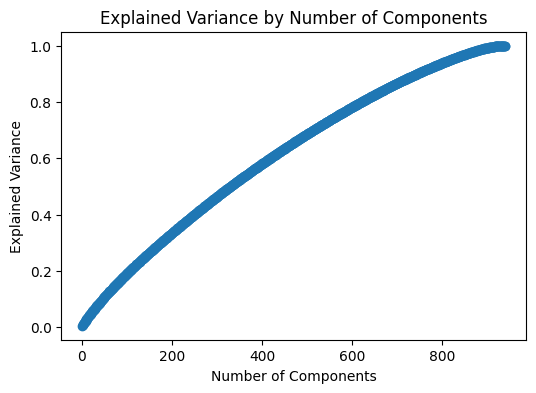

In [263]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, n_rows+1), bg_pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

# PCA Subset Selection
Based on the results above, we will select the first 81 principal components for clustering, since they contain 20% of the variance.

In [249]:
BG_N_PCS = 46

In [246]:
# use PCA for dimensionality reduction
print('performing PCA')
bg_pca_sub = PCA(n_components=BG_N_PCS)
bg_pca_sub.fit(bg_df_std)
bg_pca_scores = bg_pca_sub.transform(bg_df_std)
bg_pca_scores

performing PCA


array([[ -0.45927879,  -0.73578795,  -0.47297583, ...,   0.3774895 ,
          0.43432579,   2.11703232],
       [ -1.10317407,  -0.21098404,  -0.71148481, ...,  -8.28337325,
         -4.55683182,   5.28707016],
       [ -0.72728174,  -0.32587583,  -0.53749935, ...,   0.39618931,
          0.15135012,  -0.33350069],
       ...,
       [  1.413471  ,  -1.34519561,  -0.86148014, ...,  -1.91051694,
          7.43922316, -10.30976407],
       [  0.60505082,  -0.76754129,  -0.37675621, ...,   0.61132007,
          1.94341341,  -0.29828251],
       [ -0.91470907,  -0.53059556,  -0.17131583, ...,   0.18723934,
          0.10273416,   0.5030609 ]])

# Perform K-Means Clustering

## Select a Cluster Number

In [264]:
wcss = []
max_clusters = 80
for i in range(1, max_clusters+1):
    bg_kmeans_pca = cluster.KMeans(n_clusters=i, init='k-means++', random_state=42)
    bg_kmeans_pca.fit(bg_pca_scores)
    wcss.append(bg_kmeans_pca.inertia_)
    if i == 1:
        delta = 0
    else:
        delta = wcss[-2] - wcss[-1]
    print('{0:<2} - {1:<18} - {2:<15}'.format(i, wcss[-1], delta))

1  - 9714944.793387467  - 0              
2  - 9532915.204734653  - 182029.5886528138
3  - 9368780.688715363  - 164134.5160192903
4  - 8886386.809588581  - 482393.8791267816
5  - 8647532.502289679  - 238854.30729890242
6  - 8384745.258118719  - 262787.24417096004
7  - 8097812.5885094935 - 286932.66960922536
8  - 7833957.440191336  - 263855.14831815753
9  - 7668370.904995692  - 165586.535195644
10 - 7429512.4562551025 - 238858.44874058943
11 - 7227497.9956351565 - 202014.460619946
12 - 6970303.361372037  - 257194.63426311966
13 - 6739339.619120195  - 230963.74225184228
14 - 6517733.613512608  - 221606.00560758635
15 - 6291596.408736396  - 226137.20477621257
16 - 6118070.347393015  - 173526.06134338025
17 - 5916290.398004714  - 201779.949388301
18 - 5691467.357168782  - 224823.04083593283
19 - 5428684.904451119  - 262782.4527176628
20 - 5296269.4115922805 - 132415.4928588383
21 - 5065117.984796828  - 231151.42679545283
22 - 4906190.236215736  - 158927.74858109187
23 - 4732670.987615844  

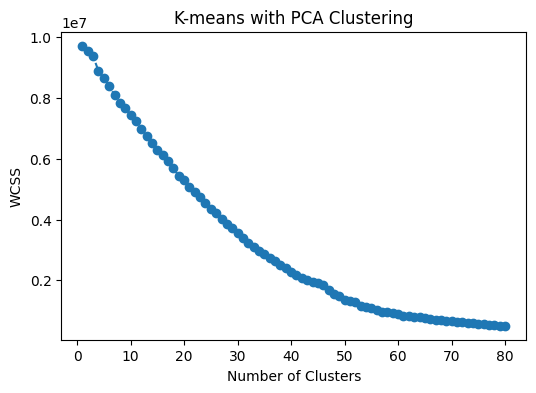

In [274]:
# plt.figure(figsize=(10, 8))
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_clusters+1), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

From the graph above, there appears to be an elbow around ~34.

In [266]:
BG_N_CLUSTERS = 40

## Perform Final Clustering

In [267]:
bg_kmeans_pca = cluster.KMeans(n_clusters=BG_N_CLUSTERS, init='k-means++', random_state=42)
bg_kmeans_pca.fit(bg_pca_scores)

KMeans(n_clusters=40, random_state=42)

## Plot (Without Labeling)

In [268]:
bg_kmeans_labels = bg_kmeans_pca.fit_predict(bg_pca_scores)

In [269]:
# set up labeling
u_labels = np.unique(bg_kmeans_labels)

In [270]:
all_colors = list(mcolors.BASE_COLORS.keys())
print(len(all_colors))
all_labels = ['o', 'x', '+', 'D', 'v', '1', 's']
color_set = []
marker_set = []
for i in u_labels:
    color_set.append(all_colors[i % len(all_colors)])
    marker_set.append(all_labels[i % len(all_labels)])
print(color_set)
print(marker_set)

8
['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
['o', 'x', '+', 'D', 'v', '1', 's', 'o', 'x', '+', 'D', 'v', '1', 's', 'o', 'x', '+', 'D', 'v', '1', 's', 'o', 'x', '+', 'D', 'v', '1', 's', 'o', 'x', '+', 'D', 'v', '1', 's', 'o', 'x', '+', 'D', 'v']


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


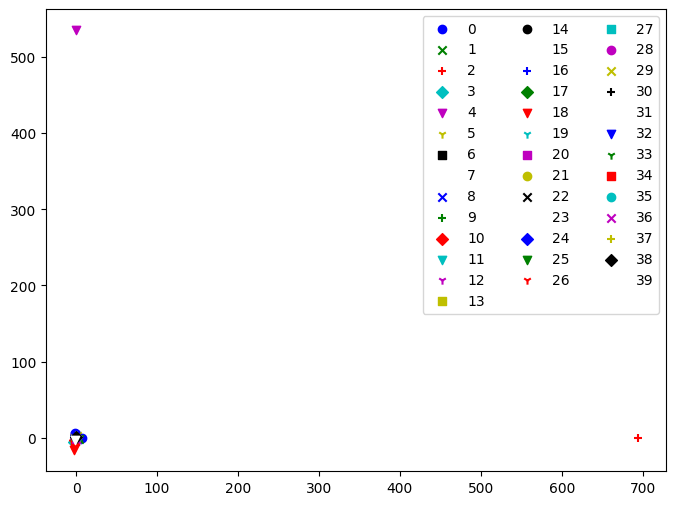

In [273]:
# plt.figure(figsize=(15,12))
plt.figure(figsize=(8,6))
print(u_labels)
m = ['o', 'x', '+']
for i in u_labels:
    # plt.scatter(bg_pca_scores[bg_kmeans_labels == i, 0], bg_pca_scores[bg_kmeans_labels == i, 1], label=i, marker=m[i%3])
    plt.scatter(bg_pca_scores[bg_kmeans_labels == i, 0], bg_pca_scores[bg_kmeans_labels == i, 1], label=i, c=color_set[i], marker=marker_set[i])
plt.legend(fontsize = 10, ncol = 3)
plt.show()

To allow for better visibility, let's filter out 2 and 5.

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


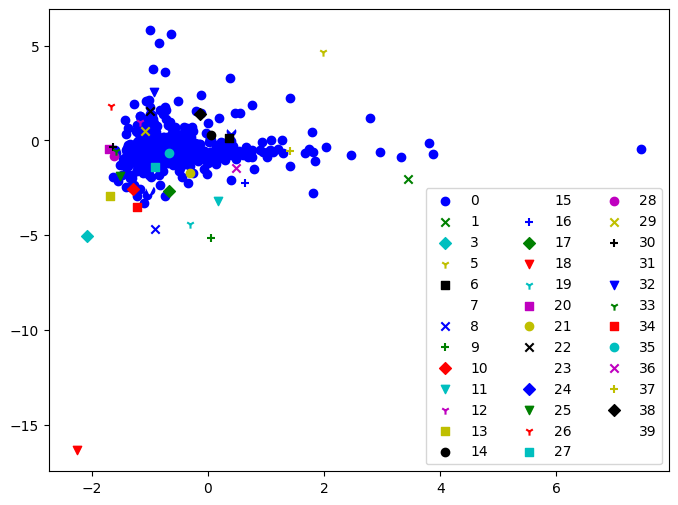

In [276]:
# plt.figure(figsize=(15,12))
plt.figure(figsize=(8,6))
u_labels = np.unique(bg_kmeans_labels)
print(u_labels)
m = ['o', 'x', '+']
for i in u_labels:
    if i == 2 or i == 4:
        continue
    # plt.scatter(bg_pca_scores[bg_kmeans_labels == i, 0], bg_pca_scores[bg_kmeans_labels == i, 1], label=i, marker=m[i%3])
    plt.scatter(bg_pca_scores[bg_kmeans_labels == i, 0], bg_pca_scores[bg_kmeans_labels == i, 1], label=i, c=color_set[i], marker=marker_set[i])
plt.legend(fontsize = 10, ncol = 3)
plt.show()

In [261]:
# if i == 32 or i == 5 or i == 23 or i == 2:
# bg_pca_scores[bg_kmeans_labels == 32,0]
for i in range(BG_N_CLUSTERS):
    n = len(bg_kmeans_labels[bg_kmeans_labels == i])
    if n > 1:
        print('{0:<2} - {1}'.format(i, n))

0  - 887
42 - 7
